In [1]:
import numpy as np
from fenics import *
from elasticity_solver import differentiable_solver

In [2]:
res_u_file = File("test/elastodynamics-u.pvd")
res_v_file = File("test/elastodynamics-v.pvd")

def save(
    timestep, 
    curr_time,
    u_field, 
    v_field, 
    a_field
):
    
    res_u_file << u_field
    res_v_file << v_field
    
solver = differentiable_solver(
    [(np.array([c, 2000.])) for c in np.linspace(0., 2000., 64)] 
)
solver.forward(
    np.random.normal(0., 1., (64, 64)), # lambda
    np.random.normal(0., 1., (64, 64)), # mu
    np.random.normal(0., 1., (64, 64)), # rho
    np.random.normal(0., 1., (100, 64)),
    save_callback=save
)

In [3]:
j, grads = solver.backward()

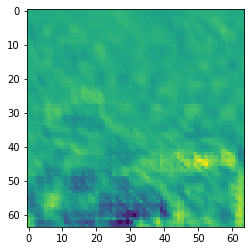

In [8]:
import matplotlib.pyplot as plt

plt.imshow(grads[1])

In [7]:
!tar cvf samples.tar test/* 

test/elastodynamics-u.pvd
test/elastodynamics-u000000.vtu
test/elastodynamics-u000001.vtu
test/elastodynamics-u000002.vtu
test/elastodynamics-u000003.vtu
test/elastodynamics-u000004.vtu
test/elastodynamics-u000005.vtu
test/elastodynamics-u000006.vtu
test/elastodynamics-u000007.vtu
test/elastodynamics-u000008.vtu
test/elastodynamics-u000009.vtu
test/elastodynamics-u000010.vtu
test/elastodynamics-u000011.vtu
test/elastodynamics-u000012.vtu
test/elastodynamics-u000013.vtu
test/elastodynamics-u000014.vtu
test/elastodynamics-u000015.vtu
test/elastodynamics-u000016.vtu
test/elastodynamics-u000017.vtu
test/elastodynamics-u000018.vtu
test/elastodynamics-u000019.vtu
test/elastodynamics-u000020.vtu
test/elastodynamics-u000021.vtu
test/elastodynamics-u000022.vtu
test/elastodynamics-u000023.vtu
test/elastodynamics-u000024.vtu
test/elastodynamics-u000025.vtu
test/elastodynamics-u000026.vtu
test/elastodynamics-u000027.vtu
test/elastodynamics-u000028.vtu
test/elastodynamics-u000029.vtu
test/elastodyn

In [3]:
import math as m

class interpolant(UserExpression):

    def __init__(self, bbox, values, **kwargs):
        
        super().__init__()
        
        self.bbox = bbox
        self.values = values
        
        self.nx = int(values.shape[0])
        self.ny = int(values.shape[1])
        
        self.dx = (self.bbox[1][0] - self.bbox[0][0]) / float(self.nx)
        self.dy = (self.bbox[1][1] - self.bbox[0][1]) / float(self.ny)
        
        print(self.dx)
        
    def eval(self, values, x):
        
        ix = int(x[0] / self.dx)
        iy = int(x[1] / self.dy)
        
        if ix == self.nx: ix -= 1
        if iy == self.ny: iy -= 1
        
        #print(2000. / self.dx)
        
        n1 = [ix - 1, iy - 1]
        n2 = [ix - 1, iy    ]
        n3 = [ix - 1, iy + 1]
        n4 = [ix    , iy - 1]
        n5 = [ix    , iy]
        n6 = [ix    , iy + 1]
        n7 = [ix + 1, iy - 1]
        n8 = [ix + 1, iy    ]
        n9 = [ix + 1, iy + 1]
        
        
        if (ix == 0): 
            n1[0] = 0
            n2[0] = 0
            n3[0] = 0
        if (iy == 0):
            n1[1] = 0
            n4[1] = 0
            n7[1] = 0
        if (ix >= self.nx - 1):
            n7[0] = self.nx - 1
            n8[0] = self.nx - 1
            n9[0] = self.nx - 1
        if (iy >= self.ny - 1):
            n3[1] = self.ny - 1
            n6[1] = self.ny - 1
            n9[1] = self.ny - 1
        
        neighbours = [
            n1, n2, n3, n4, n5, n6, n7, n8, n9]
        
        dists = np.array([
            m.sqrt((x[0] - self.dx * n[0]) ** 2 +\
            (x[1] - self.dy * n[1]) ** 2) 
            for n in neighbours
        ])
        
        idx = np.argmin(dists)         
        
        values[0] = self.values[neighbours[idx][0], neighbours[idx][1]]

In [4]:
mesh = RectangleMesh(Point(0., 0.), Point(2000., 2000.), 100, 100)
control_space = FunctionSpace(mesh, 'CG', 2)

In [5]:
f = HDF5File(mesh.mpi_comm(), "output.h5", 'r')
#f = HDF5File(mesh.mpi_comm(), "output.h5", 'w')

In [6]:
import math
from scipy.optimize import OptimizeResult

class adam_minimizer():
    
    def __init__(self, parameters=None):
        
        self.parameters = {
            'lr': 1e-3,
            'betas': (0.9, 0.99), 
            'eps': 1e-8,
            'max_iter': 10  
        }
        
        if parameters is not None:        
            for k in parameters.keys():
                if not (k in self.parameters): raise KeyError
                self.parameters[k] = parameters[k]
                
    
        
    def __call__(self, f, x_0, J, H, bounds, **kwargs):
        
        lr  = self.parameters['lr']
        b1  = self.parameters['betas'][0]
        b2  = self.parameters['betas'][1]
        eps = self.parameters['eps']
        
        # initialise optimizer state
        
        state = {
            'step': 1,
            'eval_point': x_0,
            'exp_avg': np.zeros_like(x_0),
            'exp_avg_sq': 0.0
        }
        
        num_iter = self.parameters['max_iter']
        
        for i in range(num_iter):
            
            step = state['step']
            exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
            x = state['eval_point']
            grad = J(x)
            
            exp_avg    = exp_avg * b1 + grad * (1. - b1)
            exp_avg_sq = exp_avg_sq * b2 + np.dot(grad, grad) * (1. - b2)
            
            denom = math.sqrt(exp_avg_sq) + eps
            
            bias_correction_1 = 1 / (1 - b1 ** step)
            bias_correction_2 = 1 / (1 - b2 ** step)
            
            adapted_lr = lr * bias_correction_1 / math.sqrt(bias_correction_2)
            
            x = x - adapted_lr * exp_avg / denom
            
            print(f(x))
            
            state['step']      += 1
            state['exp_avg']    = exp_avg
            state['exp_avg_sq'] = exp_avg_sq
            state['eval_point'] = x
         
        return state['eval_point']
        #return OptimizeResult(
        #    fun=f(state['eval_point']),
        #    x=state['eval_point'],
        #    nit=state['step'],
        #    succes=(state['step'] > 0)
        #) 

In [7]:
tol = 1e-14
pulse_radius = 200.


class uniform_detectors(SubDomain):
    
    def __init__(self, detector_coords): 
        super().__init__()
        self.detector_coords = detector_coords
    
    def inside(self, x, on_boundary):
        
        result = False
        for c in self.detector_coords:
            result = result or (near(x[0], c, tol) and near(x[1], 2000., tol))
            
        return on_boundary and result

    
class dirac_delta(UserExpression):
    
    def __init__(self, detector_coords): 
        super().__init__()
        self.detector_coords = detector_coords
    
    def eval(self, values, x):
        
        result = False
        for c in self.detector_coords:
            result = result or (near(x[0], c, tol) and near(x[1], 1950., tol))
            
        values[0] = float(result)
        
        return values
    
    def value_shape(self): return ()    
    
    
class boundary_top(SubDomain):
    def inside(self, x, on_boundary): 
        return on_boundary and near(x[1], 2000., tol) and ((x[0] - 1000.) ** 2 <= pulse_radius ** 2)
    
class boundary_bot(SubDomain):
    def inside(self, x, on_boundary): return on_boundary and near(x[1], 0., tol)

class boundary_left(SubDomain):
    def inside(self, x, on_boundary): return on_boundary and near(x[0], 0., tol)

class boundary_right(SubDomain):
    def inside(self, x, on_boundary): return on_boundary and near(x[0], 2000., tol)
     
top   = boundary_top()
bot   = boundary_bot()
left  = boundary_left()
right = boundary_right()


# test with dirichlet boundary condition
# TODO: free boundary?

boundaries = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
bot.mark(boundaries, 1)
top.mark(boundaries, 2)
left.mark(boundaries, 3)
right.mark(boundaries, 4)

dss = ds(subdomain_data=boundaries)

detectors_locations = [(np.array([c, 2000.])) for c in np.linspace(0., 2000., 50)]

In [8]:
# define initiall guess functions
# by splitting the subdomain in half

class upper_half(SubDomain):
    def inside(self, x, on_boundary): return x[1] > 1000.
    
    
class lambda_(UserExpression):
    
    def __init__(self, materials, lambda_0, lambda_1, **kwargs):
        
        super().__init__(**kwargs)
        
        self.materials = materials
        self.lambda_0  = lambda_0
        self.lambda_1  = lambda_1
        
    def eval_cell(self, values, x, cell):
        
        if self.materials[cell.index] == 0:
            values[0] = self.lambda_0
        else:
            values[0] = self.lambda_1
            
        return values
            
class mu_(UserExpression):
    
    def __init__(self, materials, mu_0, mu_1, **kwargs):
        
        super().__init__(**kwargs)
        
        self.materials = materials
        self.mu_0  = mu_0
        self.mu_1  = mu_1
        
    def eval_cell(self, values, x, cell):
        
        if self.materials[cell.index] == 0:
            values[0] = self.mu_0
        else:
            values[0] = self.mu_1
            
        return values

            
class rho_(UserExpression):
    
    def __init__(self, materials, rho_0, rho_1, **kwargs):
        
        super().__init__(**kwargs)
        
        self.materials = materials
        self.rho_0  = rho_0
        self.rho_1  = rho_1
        
    def eval_cell(self, values, x, cell):
        
        if self.materials[cell.index] == 0:
            values[0] = self.rho_0
        else:
            values[0] = self.rho_1
            
        return values
    
    
subdomains = MeshFunction('size_t', mesh, mesh.topology().dim())
subdomains.set_all(0)

top_half = upper_half()
top_half.mark(subdomains, 1)

# rheological parameters from diploma

pspeed_0 = 1600.
sspeed_0 = 800.
rho_0    = 1100.

pspeed_1 = 4000.
sspeed_1 = 2000.
rho_1    = 1800.

def calculate_lame_params(pspeed, sspeed, rho):
    return (pspeed ** 2 - 2. * sspeed ** 2) * rho, sspeed ** 2 * rho 

lambda_0, mu_0 = calculate_lame_params(pspeed_0, sspeed_0, rho_0)
lambda_1, mu_1 = calculate_lame_params(pspeed_1, sspeed_1, rho_1)


mu    = mu_(subdomains, mu_0, mu_1, degree=2)
rho   = rho_(subdomains, rho_0, rho_1, degree=2)
lmbda = lambda_(subdomains, lambda_0, lambda_1, degree=2)

lmbda = Function(control_space)
mu    = Function(control_space)
rho   = Function(control_space)

# initial guess is constant

scale_lambda  = Constant(1e10)
factor_lambda = Constant(1e9)

scale_rho  = Constant(1000)
factor_rho = Constant(100)
scale_mu  = Constant(1e9)
factor_mu = Constant(1e8)

# set constant prior
lmbda.assign(Constant(0.))
mu.assign(Constant(0.))
rho.assign(Constant(0.))

#lmbda = Function(control_space, 'distr_lambda.xml')
#mu    = Function(control_space, 'distr_mu.xml')
#rho   = Function(control_space, 'distr_rho.xml')

In [9]:
lmbda(0.0, 0.0)

0.0

In [10]:
alpha_m = Constant(0.)
alpha_f = Constant(0.)
gamma   = Constant(0.5+alpha_f-alpha_m)
beta    = Constant((gamma+0.5)**2/4.)

In [11]:
# Rayleigh damping coefficients
eta_m = Constant(0.)
eta_k = Constant(0.)

# Time-stepping parameters
T       = 0.4
Nsteps  = 10
dt = Constant(T/Nsteps)

In [12]:
p0 = 1e9
cutoff_Tc = T/10
# Define the loading as an expression depending on t
#p = Expression(("0", "t <= tc ? p0*t/tc : 0", "0"), t=0, tc=cutoff_Tc, p0=p0, degree=0)
#p = Expression(("t <= tc ? -p0*t/tc : 0", "0", "0"), t=0, tc=cutoff_Tc, p0=p0, degree=0)


class ConstantLoad(UserExpression):
    
    def __init__(self, t, tc, p0, **kwargs):
        super().__init__(**kwargs)
        self.t  = t
        self.tc = tc
        self.p0 = p0
        
    def eval_cell(self, values, x, cell):
        
        normal = 0.0
        cell = Cell(mesh, cell.index)
        
        for f in facets(cell):
            if f.exterior(): normal = f.normal()
        
        if isinstance(normal, float): normal = (0., 1.) 
        factor = (-self.p0 * self.t/ self.tc) if (self.t <= self.tc) else  0.
        
        values[0] = normal[0] * factor
        values[1] = normal[1] * factor
        
        return values
    
    
    def value_shape(self): return (2, )
    

p = ConstantLoad(0., cutoff_Tc, p0)

In [13]:
# Define function space for displacement, velocity and acceleration
V = VectorFunctionSpace(mesh, "CG", 2)
# Define function space for stresses
Vsig = TensorFunctionSpace(mesh, "DG", 0)

In [14]:
# Test and trial functions
du = TrialFunction(V)
u_ = TestFunction(V)
# Current (unknown) displacement

# Fields from previous time step (displacement, velocity, acceleration)
u_old = Function(V)
v_old = Function(V)
a_old = Function(V)

In [15]:
# boundary conditions
zero = Constant((0.0, 0.0))

bcs = [
    DirichletBC(V, zero, left),
    DirichletBC(V, zero, right),
    DirichletBC(V, zero, bot)
]

In [16]:
# Stress tensor
def sigma(r):
    return 2.0*(scale_mu + factor_mu * mu)*sym(grad(r)) +\
          (scale_lambda + factor_lambda * lmbda)*tr(sym(grad(r)))*Identity(len(r))

# Mass form
def m(u, u_):
    return (scale_rho + factor_rho * rho)*inner(u, u_)*dx

# Elastic stiffness form
def k(u, u_):
    return inner(sigma(u), sym(grad(u_)))*dx

# Rayleigh damping form
def c(u, u_):
    return eta_m*m(u, u_) + eta_k*k(u, u_)

# Work of external forces
def Wext(u_):
    return dot(u_, p)*dss(2)

In [17]:
a1 = Constant(1. / beta / dt ** 2)
a2 = Constant(-1. * dt / beta / dt ** 2)
a3 = Constant(-(1 - 2 * beta) / 2. / beta)

v1 = Constant(1.)
v2 = Constant(dt * (1 - gamma))
v3 = Constant(dt * gamma) 


def update_a(u, u_old, v_old, a_old, ufl=True):
    
    if ufl:
        dt_ = dt
        beta_ = beta
        return (u-u_old-dt_*v_old)/beta_/dt_**2 - (1-2*beta_)/2/beta_*a_old
        
    return FunctionAXPY([
        (a1, u),
        (-a1, u_old),
        (a2, v_old),
        (a3, a_old)
    ])


def update_v(a, u_old, v_old, a_old, ufl=True):
    if ufl:
        dt_ = dt
        gamma_ = gamma
        return v_old + dt_*((1-gamma_)*a_old + gamma_*a)
    
    return FunctionAXPY([
        (v1, v_old),
        (v2, a_old),
        (v3, a)
    ], annotate=True)

def update_fields(u, u_old, v_old, a_old):

    a = Function(V)
    a.assign(a1 * u - a1 * u_old + a2 * v_old + a3 * a_old, annotate=True)
    
    v = Function(V)
    v.assign(v1 * v_old + v2 * a_old + v3 * a, annotate=True)

    # assignment makes everything worse
    # TODO: why?
    
    u_old.assign(u, annotate=True) 
    v_old.assign(v, annotate=True)
    a_old.assign(a, annotate=True)

In [18]:
def avg(x_old, x_new, alpha):
    return alpha*x_old + (1-alpha)*x_new

# Residual
a_new = update_a(du, u_old, v_old, a_old, ufl=True)
v_new = update_v(a_new, u_old, v_old, a_old, ufl=True)
res = m(avg(a_old, a_new, alpha_m), u_) + c(avg(v_old, v_new, alpha_f), u_) \
       + k(avg(u_old, du, alpha_f), u_) - Wext(u_)
a_form = lhs(res)
L_form = rhs(res)

In [19]:
K, res = assemble_system(a_form, L_form, bcs)
solver = LUSolver(K, "petsc")
solver.parameters["symmetric"] = True

# We now initiate the time stepping loop. We will keep track of the beam vertical tip displacement over time as well as the different
# parts of the system total energy. We will also compute the stress field and save it, along with the displacement field, in a ``XDMFFile``.
# The option `flush_ouput` enables to open the result file before the loop is finished, the ``function_share_mesh`` option tells that only one
# mesh is used for all functions of a given time step (displacement and stress) while the ``rewrite_function_mesh`` enforces that the same mesh
# is used for all time steps. These two options enables writing the mesh information only once instead of :math:`2N_{steps}` times::

# Time-stepping
time = np.linspace(0, T, Nsteps+1)
sig = Function(Vsig, name="sigma")
res_u_file = File("test/elastodynamics-u.pvd")
res_s_file = File("test/elastodynamics-s.pvd")

In [20]:
def local_project(v, V, u=None):
    """Element-wise projection using LocalSolver"""
    dv = TrialFunction(V)
    v_ = TestFunction(V)
    a_proj = inner(dv, v_)*dx
    b_proj = inner(v, v_)*dx
    solver = LocalSolver(a_proj, b_proj)
    solver.factorize()
    if u is None:
        u = Function(V)
        solver.solve_local_rhs(u)
        return u
    else:
        solver.solve_local_rhs(u)
        return

In [21]:
j = 0.

ref = Function(control_space)

u = Function(V)

for (i, dt) in enumerate(np.diff(time)):
    
    t = time[i+1]
    print("Time: ", t)

    # Forces are evaluated at t_{n+1-alpha_f}=t_{n+1}-alpha_f*dt
    p.t = t-float(alpha_f*dt)

    # Solve for new displacement
    res = assemble(L_form)
    for bc in bcs: bc.apply(res)
    solver.solve(K, u.vector(), res)

    # Update old fields with new quantities
    update_fields(u, u_old, v_old, a_old)
    
    _, target_func = v_old.split()
    target_func  = project(target_func, control_space)
    
    f.read(ref, f'/target/{i}')
    
    readings_ref  = [ref(p) for p in detectors_locations]
    readings_pred = [target_func(p) for p in detectors_locations]
    
    for a, b in zip(readings_ref, readings_pred):
        print(type(a-b))
        j += 0.5 * (a - b) ** 2

    # Save solution
    res_u_file << u

    # Compute stresses and save them
    local_project(sigma(u), Vsig, sig)
    res_s_file << sig

    p.t = t

Time:  0.04
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>


Time:  0.24
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>
<class 'pyadjoint.adjfloat.AdjFloat'>


In [25]:
adam = adam_minimizer()

In [ ]:
%%time

j+= 10. * assemble(
    dot(grad(lmbda), grad(lmbda)) * dx +\
    dot(grad(mu   ), grad(mu   )) * dx +\
    dot(grad(rho  ), grad(rho  )) * dx
)

controls = [Control(lmbda), Control(mu), Control(rho)]

def eval_cb(j, m):
    """ The callback function keeping a log """
    print("objective = %15.10e " % j)
    plot(m[0])

# Prepare the reduced functional
rf = ReducedFunctional(j, controls, eval_cb_post=eval_cb)

# Run the optimisation
omega_opt = minimize(rf, method="Custom", algorithm=adam)

objective = 1.0392490545e+07 
10392490.54539969
objective = 3.1898520439e+06 
3189852.0438883123
objective = 4.4724179095e+06 
4472417.909519872
objective = 6.6171195877e+06 
6617119.5877119675
objective = 9.0421996734e+06 
9042199.673400028


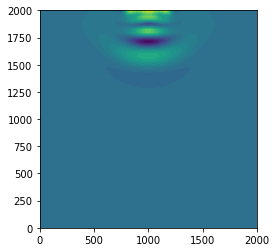

In [45]:
plot(omega_opt[0])

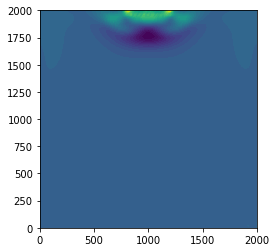

In [46]:
plot(scale_mu  + factor_mu * omega_opt[1])

In [22]:
type(u_old)

fenics_adjoint.types.function.Function

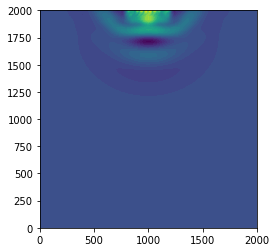

In [47]:
plot(scale_rho  + factor_rho * omega_opt[2])

In [12]:
!rm test/*

rm: cannot remove 'test/*': No such file or directory
